# Velocity benchmark

## Library imports

In [ ]:
import os
import sys

from paths import DATA_DIR, FIG_DIR
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind, wilcoxon

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib import rcParams
from matplotlib.patches import Patch

In [1]:
import cellrank as cr
import scanpy as sc
import scvelo as scv

sys.path.append("../..")

[rank: 0] Global seed set to 0


## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "hematopoiesis" / "velocity_benchmark", exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / "hematopoiesis" / "velocity_benchmark", exist_ok=True)

## Functions defination

In [4]:
def get_significance(pvalue) -> str:
    """TODO."""
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [5]:
def reverse_cluster(cluster):
    """TODO."""
    parts = cluster.split(" - ")
    reversed_parts = " - ".join(parts[::-1])
    return reversed_parts


def reverse_key(key):
    """TODO."""
    parts = key.split(" - ")
    reversed_parts = " - ".join(parts[::-1])
    return reversed_parts


def reverse_cluster_dict(cluster_dict):
    """TODO."""

    def reverse_cluster(cluster):
        parts = cluster.split(" - ")
        reversed_parts = " - ".join(parts[::-1])
        return reversed_parts

    reversed_dict = {}
    for key, value in cluster_dict.items():
        reversed_key = reverse_cluster(key)
        reversed_dict[reversed_key] = value

    return reversed_dict

In [6]:
def generate_sequence(k, n):
    """TODO."""
    sequence = list(range(1, k + 1))

    # If the length of the sequence is already >= n, trim it to n
    if len(sequence) >= n:
        return sequence[:n]

    # Fill the rest of the sequence with the number k
    sequence.extend([k] * (n - len(sequence)))

    return sequence


def stair_vec(kernel, threshold, terminal_states, cluster_key, all_dict, max_states=12):
    """TODO."""
    pre_value = []
    for num_macro in range(1, max_states):
        try:
            # Append the result to the list
            kernel.compute_macrostates(n_states=num_macro, cluster_key=cluster_key)
            kernel.predict_terminal_states(stability_threshold=threshold)
            pre_terminal = kernel.terminal_states.cat.categories.tolist()
            subset_dict = {key: all_dict[key] for key in pre_terminal}
            pre_terminal_names = list(subset_dict.values())
            pre_terminal_names = list(set(pre_terminal_names))
            pre_value.append(len(set(pre_terminal_names).intersection(terminal_states)))
        except Exception as e:
            # Handle the error, print a message or take any other action
            print(f"Error: {e}")
            # Append 0 to the list as a placeholder for the error
            pre_value.append(pre_value[len(pre_value) - 1])
            raise
        print(pre_value)
    return pre_value


def TSI_score(points, cluster_key, terminal_states, kernel, all_dict, max_states=12):
    """TODO."""
    x_values = range(0, max_states)
    y_values = [0] + generate_sequence(len(terminal_states), max_states - 1)
    area_gs = 0
    for i in range(len(x_values) - 1):
        # 计算当前矩形的面积并加到总面积上
        area_gs += (x_values[i + 1] - x_values[i]) * y_values[i]

    tsi_score = []
    for p in points:
        pre_value = stair_vec(kernel, p, terminal_states, cluster_key, all_dict, max_states)
        x_values = range(0, max_states)
        y_values = [0] + pre_value
        area_velo = 0
        for i in range(len(x_values) - 1):
            area_velo += (x_values[i + 1] - x_values[i]) * y_values[i]
        tsi_score.append(area_velo / area_gs)
    return tsi_score

In [7]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    """TODO."""
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )

In [8]:
def cal_cell_fate(adata_target, terminal_states, n_states=7):
    """TODO."""
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            terminal_id.append(i + "_" + str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))

    vk = cr.kernels.VelocityKernel(adata_target).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    # ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g2 = cr.estimators.GPCCA(combined_kernel)
    ## evaluate the fate prob on original space
    g2.compute_macrostates(n_states=n_states, n_cells=30, cluster_key="cell_type")
    ## set a high number of states, and merge some of them and rename
    terminal_states_perturb = g2.macrostates.cat.categories.tolist()
    terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
    subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
    terminal_states_perturb_names = list(subset_dict.values())
    ## check if all terminal state is coverred
    if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
        ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
    g2.set_terminal_states(terminal_states_perturb)
    g2.compute_fate_probabilities(solver="direct")
    fb = g2.fate_probabilities
    sampleID = adata_target.obs.index.tolist()
    fate_name = fb.names.tolist()
    fb = pd.DataFrame(fb, index=sampleID, columns=fate_name)
    fate_prob2 = pd.DataFrame(columns=terminal_states, index=sampleID)
    for i in terminal_states:
        fate_prob2.loc[:, i] = fb.loc[:, [j == i for j in terminal_states_perturb_names]].sum(1).tolist()

    return fate_prob2


def upper_triangular_correlation_values(A, A_hat):
    """TODO."""
    # Ensure the matrices have the same dimensions
    assert A.shape == A_hat.shape, "The matrices must have the same shape"
    # Number of columns (features)
    p = A.shape[1]
    # Initialize the correlation matrix
    upper_triangular_values = []
    # Calculate the correlation matrix
    for i in range(p):
        upper_triangular_values.append(scipy.stats.spearmanr(A[:, i], A_hat[:, i])[0])

    return upper_triangular_values

## Benchmark regularization effects

### Load unregularized model

In [9]:
adata = sc.read_h5ad(DATA_DIR / "hematopoiesis" / "rgv_adata.h5ad")
adata.X = adata.layers["Ms"]
sc.tl.pca(adata)
del adata.var["velocity_genes"]

computing velocity graph (using 1/112 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


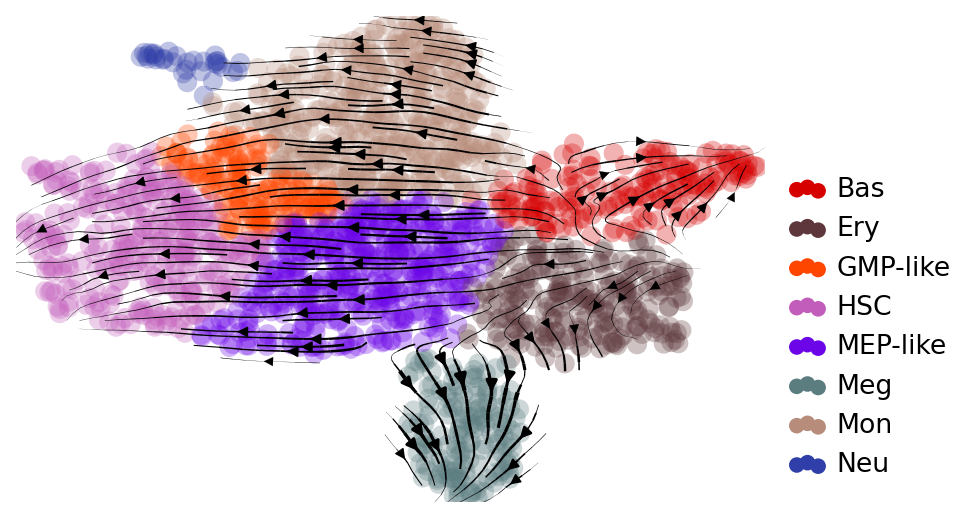

In [10]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis="umap", color="cell_type", title="", legend_loc="lower right", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "vec_filed_rgv_raw.svg",
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

### compute kernel matrix

In [11]:
rgvk = cr.kernels.VelocityKernel(adata)
rgvk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
rgvk_raw = rgvk

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

### Load regularized model

In [12]:
adata_rgv = sc.read_h5ad(DATA_DIR / "hematopoiesis" / "rgv_adata_re.h5ad")
adata_rgv.X = adata_rgv.layers["Ms"]
sc.tl.pca(adata_rgv)
del adata_rgv.var["velocity_genes"]

computing velocity graph (using 1/112 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


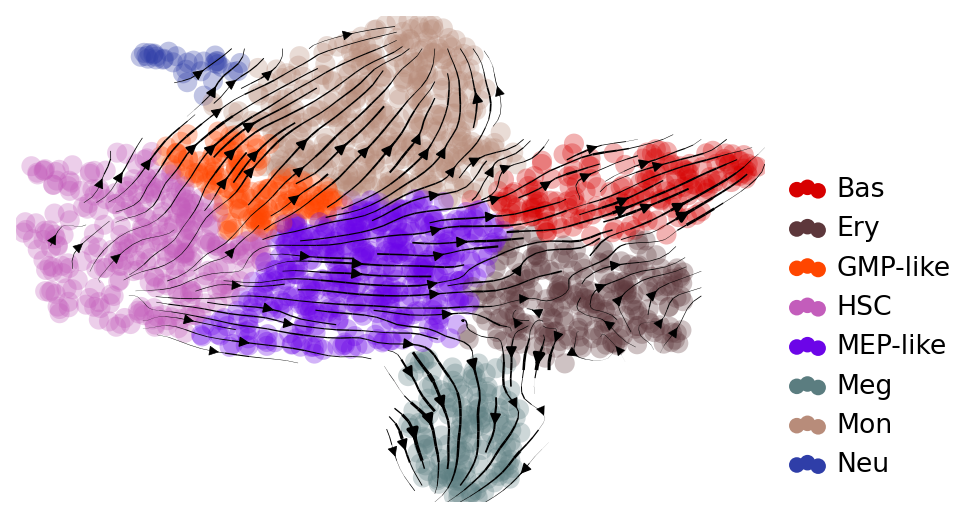

In [13]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.tl.velocity_graph(adata_rgv)
    scv.pl.velocity_embedding_stream(
        adata_rgv, basis="umap", color="cell_type", title="", legend_loc="lower right", ax=ax
    )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "vec_filed_rgv_re.svg",
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

### compute kernel matrix

In [14]:
rgvk = cr.kernels.VelocityKernel(adata_rgv)
rgvk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_rgv).compute_transition_matrix()
rgvk_new = rgvk

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

### Benchmark regularization effects

In [15]:
## measure cell state transition
STATE_TRANSITIONS = [
    ("HSC", "GMP-like"),
    ("GMP-like", "Mon"),
    ("HSC", "MEP-like"),
    ("MEP-like", "Ery"),
    ("MEP-like", "Meg"),
    ("MEP-like", "Bas"),
]

STATE_TRANSITIONS_REVERSE = [
    ("GMP-like", "HSC"),
    ("Mon", "GMP-like"),
    ("MEP-like", "HSC"),
    ("Ery", "MEP-like"),
    ("Meg", "MEP-like"),
    ("Bas", "MEP-like"),
]

In [16]:
cluster_key = "cell_type"
rep = "X_pca"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv_new = rgvk_new.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_rgv_raw = rgvk_raw.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv_new),
                "Log ratio": np.log((cbc_rgv_new + 1) / (cbc_rgv_raw + 1)),
            }
        )
    )
score_df1 = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


In [17]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df1["State transition"].isin([f"{source} - {target}"])
    a = score_df1.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [18]:
significances1 = significances.copy()
significances1

{'HSC - GMP-like': '**',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': '***'}

In [19]:
score_df = []
for source, target in tqdm(STATE_TRANSITIONS_REVERSE):
    cbc_rgv_new = rgvk_new.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_rgv_raw = rgvk_raw.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv_new),
                "Log ratio": np.log((2 - cbc_rgv_new) / (2 - cbc_rgv_raw)),
            }
        )
    )
score_df2 = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


In [20]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS_REVERSE:
    obs_mask = score_df2["State transition"].isin([f"{source} - {target}"])
    a = score_df2.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [21]:
significances2 = significances.copy()
significances2

{'GMP-like - HSC': '***',
 'Mon - GMP-like': '***',
 'MEP-like - HSC': '***',
 'Ery - MEP-like': '*',
 'Meg - MEP-like': 'n.s.',
 'Bas - MEP-like': 'n.s.'}

In [22]:
significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}

palette1 = {
    state_transition: significance_palette[significance] for state_transition, significance in significances1.items()
}
palette2 = {
    state_transition: significance_palette[significance] for state_transition, significance in significances2.items()
}

In [23]:
score_df2["State transition"] = score_df2["State transition"].apply(reverse_cluster)
palette2 = {reverse_key(key): value for key, value in palette2.items()}

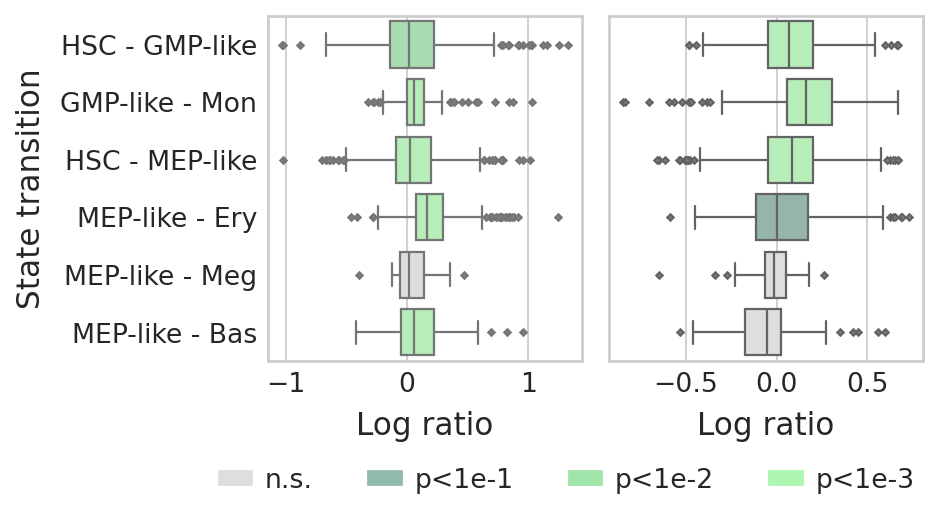

In [24]:
## merge two boxplot and plot them jointly
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

    ax = axes[0]
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(
        data=score_df1,
        y="State transition",
        x="Log ratio",
        palette=palette1,
        ax=ax,
        flierprops=flierprops,
    )

    ax = axes[1]
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(
        data=score_df2,
        y="State transition",
        x="Log ratio",
        palette=palette2,
        ax=ax,
        flierprops=flierprops,
    )

    handles = [Patch(label=label, facecolor=color) for label, color in significance_palette.items()]
    fig.legend(
        handles=handles,
        labels=["n.s.", "p<1e-1", "p<1e-2", "p<1e-3"],
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.6, -0.1),
    )
    fig.tight_layout()
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "transition_benchmark_velocity.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

In [25]:
score_df1.loc[:, "Direction"] = "Forward"
score_df2.loc[:, "Direction"] = "Backward"
score_df = pd.concat([score_df1, score_df2])

In [26]:
significances2 = reverse_cluster_dict(significances2)
significances2

{'HSC - GMP-like': '***',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '*',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': 'n.s.'}

In [27]:
score = []
for i in list(significances1.keys()):
    score.append(significances1[i])

score2 = []
for i in list(significances2.keys()):
    score2.append(significances2[i])

In [28]:
sig_m = pd.DataFrame(
    {
        "State transition": list(significances1.keys()) + list(significances2.keys()),
        "Direction": ["Forward"] * 6 + ["Backward"] * 6,
        "Sign": score + score2,
    }
)

In [29]:
score_df

,State transition,Log ratio,Direction
0,HSC - GMP-like,-0.165089,Forward
1,HSC - GMP-like,0.274779,Forward
2,HSC - GMP-like,0.043458,Forward
3,HSC - GMP-like,-0.089219,Forward
4,HSC - GMP-like,-0.084051,Forward
...,...,...,...
139,MEP-like - Bas,0.219536,Backward
140,MEP-like - Bas,-0.066843,Backward
141,MEP-like - Bas,0.013242,Backward
142,MEP-like - Bas,-0.010984,Backward


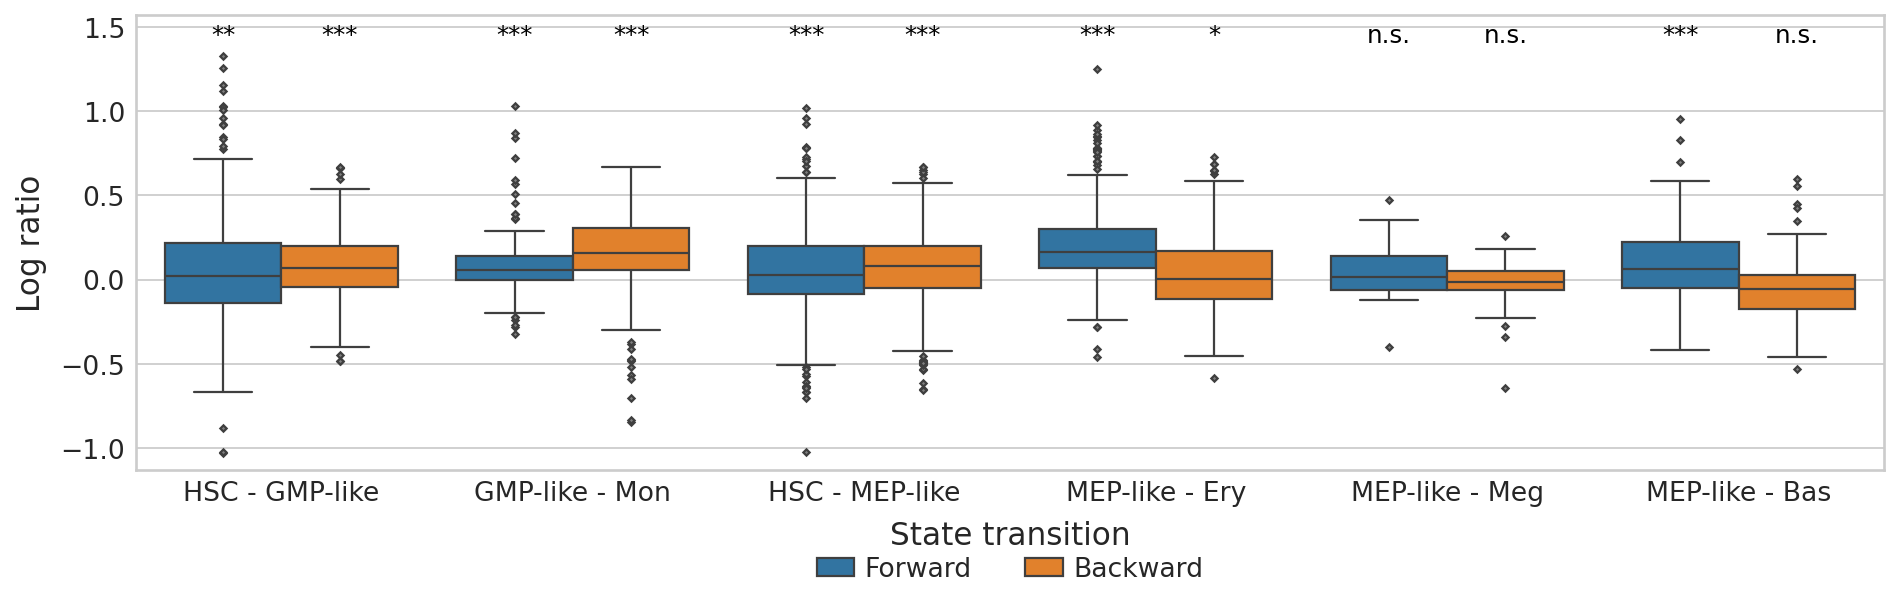

In [30]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(x="State transition", y="Log ratio", hue="Direction", data=score_df, flierprops=flierprops, ax=ax)

    # Calculate the maximum Y value from the data to set a uniform height for significance indicators
    y_max = score_df["Log ratio"].max()

    # Add significance indicators
    cell_types = score_df["State transition"].unique()
    categories = score_df["Direction"].unique()

    for i, cell_type in enumerate(cell_types):
        for j, category in enumerate(categories):
            star = sig_m[(sig_m["State transition"].isin([cell_type])) & (sig_m["Direction"].isin([category]))][
                "Sign"
            ].tolist()[0]

            # Calculate the position of the asterisk
            x = i + (j - 0.5) * 0.4  # Adjust the position of the asterisk
            y = y_max + 0.05  # Uniform height for all asterisks

            ax.text(x, y, star, ha="center", va="bottom", color="black")

    plt.ylim(score_df["Log ratio"].min() - 0.1, score_df["Log ratio"].max() + 0.24)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(categories))
    # Apply tight layout
    plt.tight_layout()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "transition_benchmark_velocity.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Benchmark RegVelo with scVelo

In [31]:
adata = sc.read_h5ad(DATA_DIR / "hematopoiesis" / "scv_adata.h5ad")
adata.X = adata.layers["Ms"]
sc.tl.pca(adata)
del adata.var["velocity_genes"]

computing velocity graph (using 1/112 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


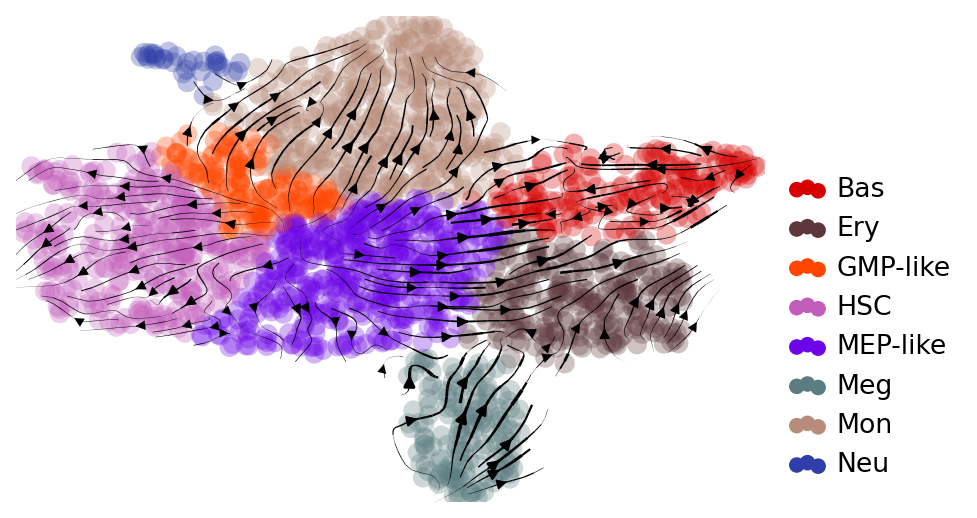

In [32]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis="umap", color="cell_type", title="", legend_loc="lower right", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "vec_filed_scvelo.svg",
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

In [33]:
svk = cr.kernels.VelocityKernel(adata)
svk.compute_transition_matrix()

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

VelocityKernel[n=1947, model='deterministic', similarity='correlation', softmax_scale=17.459]

In [34]:
cluster_key = "cell_type"
rep = "X_pca"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv = rgvk_new.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = svk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_scv + 1)),
            }
        )
    )
score_df1 = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


In [35]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df1["State transition"].isin([f"{source} - {target}"])
    a = score_df1.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [36]:
significances1 = significances.copy()
significances1

{'HSC - GMP-like': '*',
 'GMP-like - Mon': '*',
 'HSC - MEP-like': 'n.s.',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': '**'}

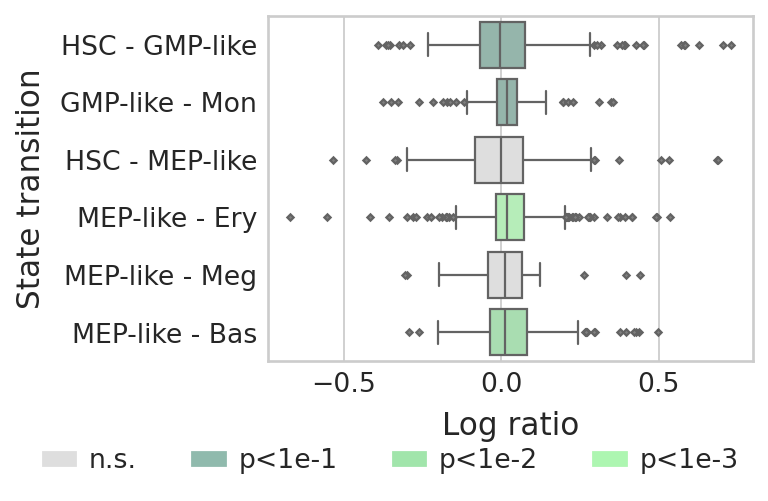

In [37]:
palette1 = {
    state_transition: significance_palette[significance] for state_transition, significance in significances.items()
}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 3))

    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(
        data=score_df1,
        y="State transition",
        x="Log ratio",
        palette=palette1,
        ax=ax,
        flierprops=flierprops,
    )

    # ax.tick_params(axis="x", rotation=45)

    handles = [Patch(label=label, facecolor=color) for label, color in significance_palette.items()]
    fig.legend(
        handles=handles,
        labels=["n.s.", "p<1e-1", "p<1e-2", "p<1e-3"],
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.06),
    )
    fig.tight_layout()
    plt.show()

In [38]:
score_df = []
for source, target in tqdm(STATE_TRANSITIONS_REVERSE):
    cbc_rgv = rgvk_new.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = svk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((2 - cbc_rgv) / (2 - cbc_scv)),
            }
        )
    )
score_df2 = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


In [39]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS_REVERSE:
    obs_mask = score_df2["State transition"].isin([f"{source} - {target}"])
    a = score_df2.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [40]:
significances2 = significances.copy()
significances2

{'GMP-like - HSC': '***',
 'Mon - GMP-like': '***',
 'MEP-like - HSC': 'n.s.',
 'Ery - MEP-like': 'n.s.',
 'Meg - MEP-like': '***',
 'Bas - MEP-like': '***'}

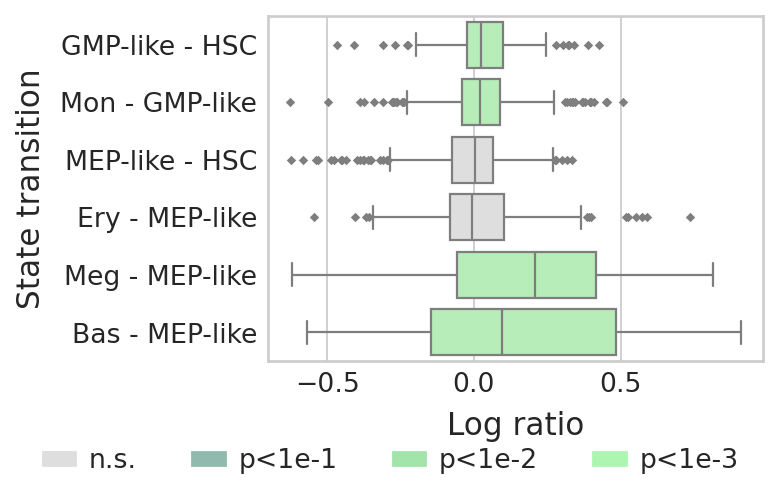

In [41]:
significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}

palette2 = {
    state_transition: significance_palette[significance] for state_transition, significance in significances.items()
}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 3))

    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(
        data=score_df2,
        y="State transition",
        x="Log ratio",
        palette=palette2,
        ax=ax,
        flierprops=flierprops,
    )

    # ax.tick_params(axis="x", rotation=45)

    handles = [Patch(label=label, facecolor=color) for label, color in significance_palette.items()]
    fig.legend(
        handles=handles,
        labels=["n.s.", "p<1e-1", "p<1e-2", "p<1e-3"],
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.06),
    )
    fig.tight_layout()
    plt.show()

In [42]:
score_df2["State transition"] = score_df2["State transition"].apply(reverse_cluster)
palette2 = {reverse_key(key): value for key, value in palette2.items()}

In [43]:
score_df1.loc[:, "Direction"] = "Forward"
score_df2.loc[:, "Direction"] = "Backward"
score_df = pd.concat([score_df1, score_df2])

In [44]:
significances2 = reverse_cluster_dict(significances2)
significances2

{'HSC - GMP-like': '***',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': 'n.s.',
 'MEP-like - Ery': 'n.s.',
 'MEP-like - Meg': '***',
 'MEP-like - Bas': '***'}

In [45]:
score = []
for i in list(significances1.keys()):
    score.append(significances1[i])

score2 = []
for i in list(significances2.keys()):
    score2.append(significances2[i])

In [46]:
sig_m = pd.DataFrame(
    {
        "State transition": list(significances1.keys()) + list(significances2.keys()),
        "Direction": ["Forward"] * 6 + ["Backward"] * 6,
        "Sign": score + score2,
    }
)

In [47]:
score_df

,State transition,Log ratio,Direction
0,HSC - GMP-like,0.160760,Forward
1,HSC - GMP-like,0.578033,Forward
2,HSC - GMP-like,-0.221612,Forward
3,HSC - GMP-like,0.017876,Forward
4,HSC - GMP-like,-0.046201,Forward
...,...,...,...
139,MEP-like - Bas,-0.319145,Backward
140,MEP-like - Bas,0.771164,Backward
141,MEP-like - Bas,0.165385,Backward
142,MEP-like - Bas,0.285394,Backward


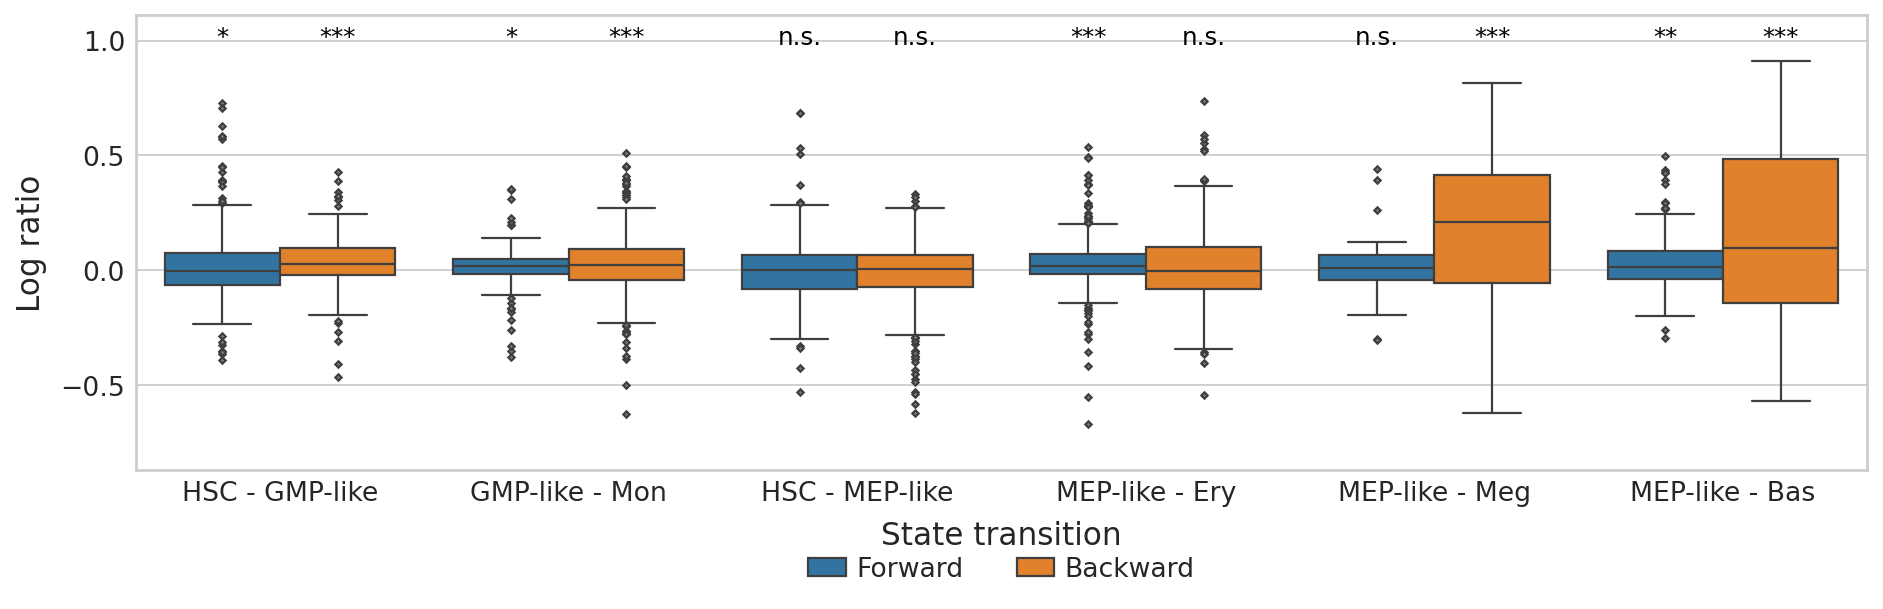

In [48]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(x="State transition", y="Log ratio", hue="Direction", data=score_df, flierprops=flierprops, ax=ax)

    # Calculate the maximum Y value from the data to set a uniform height for significance indicators
    y_max = score_df["Log ratio"].max()

    # Add significance indicators
    cell_types = score_df["State transition"].unique()
    categories = score_df["Direction"].unique()

    for i, cell_type in enumerate(cell_types):
        for j, category in enumerate(categories):
            star = sig_m[(sig_m["State transition"].isin([cell_type])) & (sig_m["Direction"].isin([category]))][
                "Sign"
            ].tolist()[0]

            # Calculate the position of the asterisk
            x = i + (j - 0.5) * 0.4  # Adjust the position of the asterisk
            y = y_max + 0.05  # Uniform height for all asterisks

            ax.text(x, y, star, ha="center", va="bottom", color="black")

    plt.ylim(score_df["Log ratio"].min() - 0.2, score_df["Log ratio"].max() + 0.2)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(categories))
    # Apply tight layout
    plt.tight_layout()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "rgv_scv.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Benchmark RegVelo with veloVI

In [49]:
adata = sc.read_h5ad(DATA_DIR / "hematopoiesis" / "vi_adata.h5ad")
adata.X = adata.layers["Ms"]
sc.tl.pca(adata)
del adata.var["velocity_genes"]

computing velocity graph (using 1/112 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


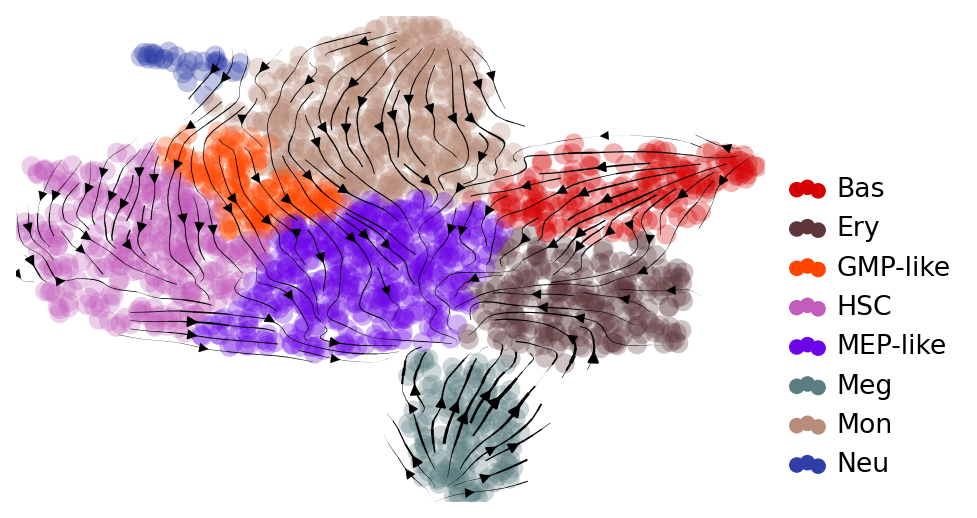

In [50]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis="umap", color="cell_type", title="", legend_loc="lower right", ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "vec_filed_velovi.svg",
        format="svg",
        transparent=True,
        bbox_inches="tight",
    )

In [51]:
vik = cr.kernels.VelocityKernel(adata)
vik.compute_transition_matrix()

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

VelocityKernel[n=1947, model='deterministic', similarity='correlation', softmax_scale=12.14]

In [52]:
cluster_key = "cell_type"
rep = "X_pca"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_rgv = rgvk_new.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = vik.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((cbc_rgv + 1) / (cbc_scv + 1)),
            }
        )
    )
score_df1 = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


In [53]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df1["State transition"].isin([f"{source} - {target}"])
    a = score_df1.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [54]:
significances1 = significances.copy()
significances1

{'HSC - GMP-like': 'n.s.',
 'GMP-like - Mon': '*',
 'HSC - MEP-like': 'n.s.',
 'MEP-like - Ery': 'n.s.',
 'MEP-like - Meg': 'n.s.',
 'MEP-like - Bas': '*'}

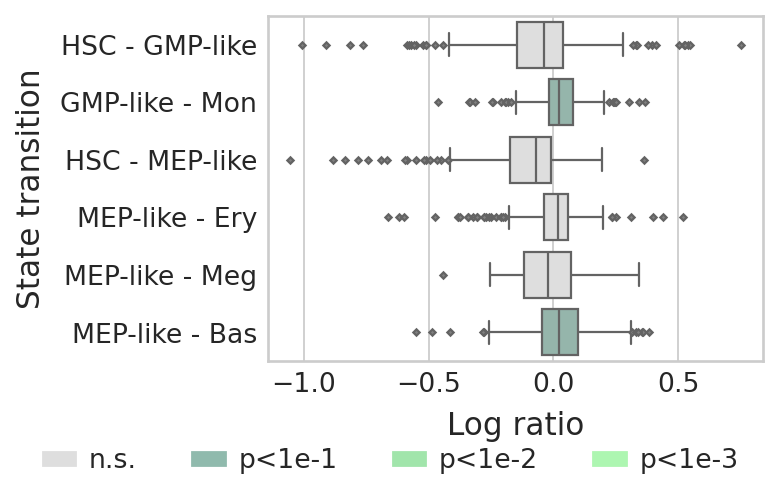

In [55]:
palette1 = {
    state_transition: significance_palette[significance] for state_transition, significance in significances.items()
}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 3))

    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(
        data=score_df1,
        y="State transition",
        x="Log ratio",
        palette=palette1,
        ax=ax,
        flierprops=flierprops,
    )

    # ax.tick_params(axis="x", rotation=45)

    handles = [Patch(label=label, facecolor=color) for label, color in significance_palette.items()]
    fig.legend(
        handles=handles,
        labels=["n.s.", "p<1e-1", "p<1e-2", "p<1e-3"],
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.06),
    )
    fig.tight_layout()
    plt.show()

In [56]:
score_df = []
for source, target in tqdm(STATE_TRANSITIONS_REVERSE):
    cbc_rgv = rgvk_new.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_scv = vik.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_rgv),
                "Log ratio": np.log((2 - cbc_rgv) / (2 - cbc_scv)),
            }
        )
    )
score_df2 = pd.concat(score_df)

100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


In [57]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS_REVERSE:
    obs_mask = score_df2["State transition"].isin([f"{source} - {target}"])
    a = score_df2.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

In [58]:
significances2 = significances.copy()
significances2

{'GMP-like - HSC': '***',
 'Mon - GMP-like': '***',
 'MEP-like - HSC': '***',
 'Ery - MEP-like': '***',
 'Meg - MEP-like': '***',
 'Bas - MEP-like': '***'}

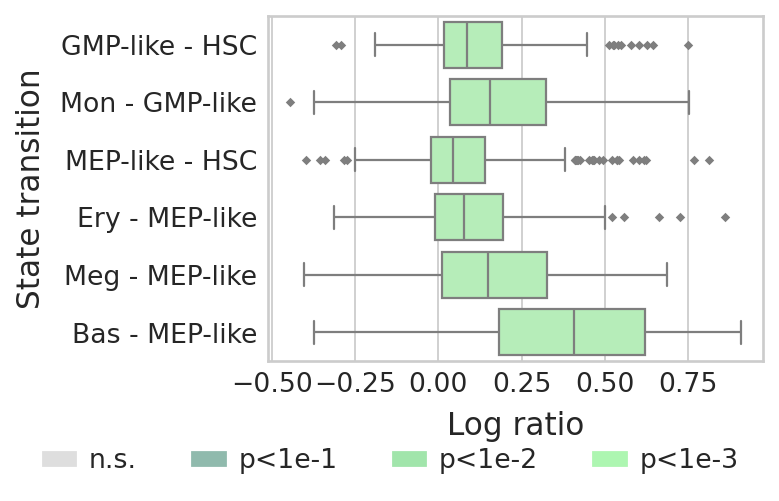

In [59]:
significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}

palette2 = {
    state_transition: significance_palette[significance] for state_transition, significance in significances.items()
}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 3))

    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(
        data=score_df2,
        y="State transition",
        x="Log ratio",
        palette=palette2,
        ax=ax,
        flierprops=flierprops,
    )

    # ax.tick_params(axis="x", rotation=45)

    handles = [Patch(label=label, facecolor=color) for label, color in significance_palette.items()]
    fig.legend(
        handles=handles,
        labels=["n.s.", "p<1e-1", "p<1e-2", "p<1e-3"],
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.06),
    )
    fig.tight_layout()
    plt.show()

In [60]:
score_df2["State transition"] = score_df2["State transition"].apply(reverse_cluster)
palette2 = {reverse_key(key): value for key, value in palette2.items()}

In [61]:
score_df1.loc[:, "Direction"] = "Forward"
score_df2.loc[:, "Direction"] = "Backward"
score_df = pd.concat([score_df1, score_df2])

In [62]:
significances2 = reverse_cluster_dict(significances2)
significances2

{'HSC - GMP-like': '***',
 'GMP-like - Mon': '***',
 'HSC - MEP-like': '***',
 'MEP-like - Ery': '***',
 'MEP-like - Meg': '***',
 'MEP-like - Bas': '***'}

In [63]:
score = []
for i in list(significances1.keys()):
    score.append(significances1[i])

score2 = []
for i in list(significances2.keys()):
    score2.append(significances2[i])

In [64]:
sig_m = pd.DataFrame(
    {
        "State transition": list(significances1.keys()) + list(significances2.keys()),
        "Direction": ["Forward"] * 6 + ["Backward"] * 6,
        "Sign": score + score2,
    }
)

In [65]:
score_df

,State transition,Log ratio,Direction
0,HSC - GMP-like,0.079630,Forward
1,HSC - GMP-like,0.265897,Forward
2,HSC - GMP-like,-0.229763,Forward
3,HSC - GMP-like,-0.083438,Forward
4,HSC - GMP-like,-0.027095,Forward
...,...,...,...
139,MEP-like - Bas,0.401443,Backward
140,MEP-like - Bas,0.770501,Backward
141,MEP-like - Bas,0.671479,Backward
142,MEP-like - Bas,0.813349,Backward


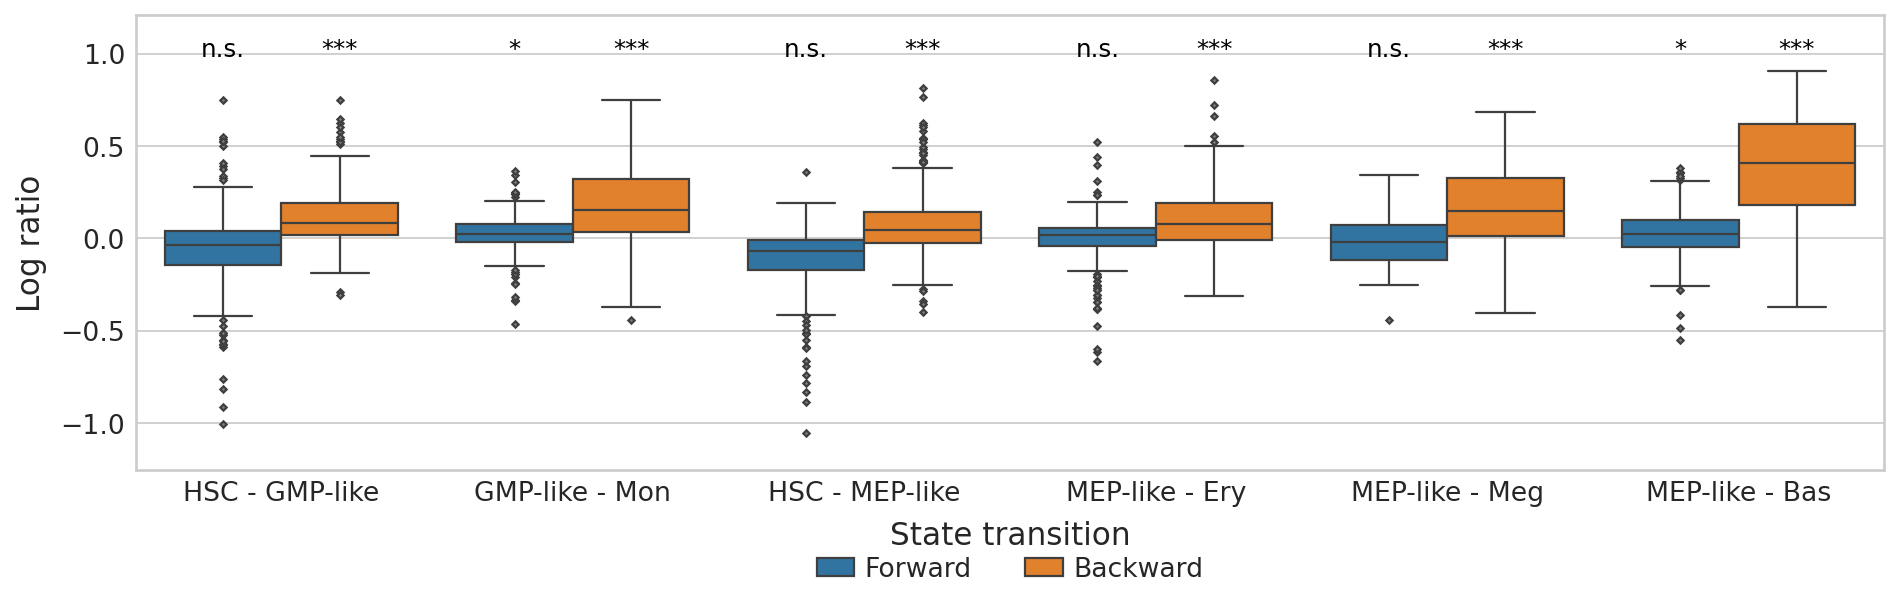

In [66]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
    flierprops = {"marker": "D", "markerfacecolor": "grey", "linestyle": "none", "markersize": 2}
    sns.boxplot(x="State transition", y="Log ratio", hue="Direction", data=score_df, flierprops=flierprops, ax=ax)

    # Calculate the maximum Y value from the data to set a uniform height for significance indicators
    y_max = score_df["Log ratio"].max()

    # Add significance indicators
    cell_types = score_df["State transition"].unique()
    categories = score_df["Direction"].unique()

    for i, cell_type in enumerate(cell_types):
        for j, category in enumerate(categories):
            star = sig_m[(sig_m["State transition"].isin([cell_type])) & (sig_m["Direction"].isin([category]))][
                "Sign"
            ].tolist()[0]

            # Calculate the position of the asterisk
            x = i + (j - 0.5) * 0.4  # Adjust the position of the asterisk
            y = y_max + 0.05  # Uniform height for all asterisks

            ax.text(x, y, star, ha="center", va="bottom", color="black")

    plt.ylim(score_df["Log ratio"].min() - 0.2, score_df["Log ratio"].max() + 0.3)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(categories))
    # Apply tight layout
    plt.tight_layout()
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "rgv_velovi.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Terminal state identification

In [67]:
terminal_states = ["Ery", "Mon", "Bas", "Neu", "Meg"]

all_states = list(set(adata.obs["cell_type"].tolist()))

all_id = all_states.copy()
all_type = all_states.copy()
for i in all_states:
    for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        all_id.append(i + "_" + str(j))
        all_type.append(i)
all_dict = dict(zip(all_id, all_type))

In [68]:
points = np.linspace(0.1, 1, 21)[:20]

In [69]:
g = cr.estimators.GPCCA(rgvk_new)
tsi = TSI_score(points, "cell_type", terminal_states, g, all_dict)

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
[1, 2, 3, 3, 4]
[1, 2, 3, 3, 4, 5]
[1, 2, 3, 3, 4, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
[1, 2, 3, 3, 4]
[1, 2, 3, 3, 4, 5]
[1, 2, 3, 3, 4, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
[1, 2, 3, 3, 4]
[1, 2, 3, 3, 4, 5]
[1, 2, 3, 3, 4, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
[1, 2, 3, 3, 4]
[1, 2, 3, 3, 4, 5]
[1, 2, 3, 3, 4, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
[1, 2, 3, 3, 4]
[1, 2, 3, 3, 4, 5]
[1, 2, 3, 3, 4, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5

In [70]:
g = cr.estimators.GPCCA(rgvk_new)
pre_value_rgv = stair_vec(g, 0.75, terminal_states, "cell_type", all_dict)

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
[1, 2, 3, 3, 4]
[1, 2, 3, 3, 4, 5]
[1, 2, 3, 3, 4, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5]
[1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5]


In [71]:
g = cr.estimators.GPCCA(svk)
tsi_scv = TSI_score(points, "cell_type", terminal_states, g, all_dict)

[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 3]
[1, 2, 2, 2, 3, 3, 4]
[1, 2, 2, 2, 3, 3, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 3]
[1, 2, 2, 2, 3, 3, 4]
[1, 2, 2, 2, 3, 3, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 3]
[1, 2, 2, 2, 3, 3, 4]
[1, 2, 2, 2, 3, 3, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 3]
[1, 2, 2, 2, 3, 3, 4]
[1, 2, 2, 2, 3, 3, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3]
[1, 2, 2, 2, 3, 3, 4, 4, 4, 3, 4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 3]
[1, 2, 2, 2, 3, 3, 4]
[1, 2, 2, 2, 3, 3, 4, 4]
[1, 2, 2, 2, 3, 3, 4, 4, 4]
[1, 2, 2, 2, 3, 3, 4

In [72]:
g = cr.estimators.GPCCA(svk)
pre_value_scv = stair_vec(g, 0.75, terminal_states, "cell_type", all_dict)

[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 2]
[1, 2, 2, 2, 3]
[1, 2, 2, 2, 3, 3]
[1, 2, 2, 2, 3, 3, 2]
[1, 2, 2, 2, 3, 3, 2, 2]
[1, 2, 2, 2, 3, 3, 2, 2, 2]
[1, 2, 2, 2, 3, 3, 2, 2, 2, 1]
[1, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1]


In [73]:
g = cr.estimators.GPCCA(vik)
tsi_vi = TSI_score(points, "cell_type", terminal_states, g, all_dict)

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 3, 4, 4]
[1, 2, 3, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 3, 4, 4]
[1, 2, 3, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 3, 4, 4]
[1, 2, 3, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4]
[1, 2, 3, 4, 4, 4, 4, 4, 4]


In [74]:
g = cr.estimators.GPCCA(vik)
pre_value_vi = stair_vec(g, 0.75, terminal_states, "cell_type", all_dict)

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 3]
Error: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
[1, 2, 3, 3, 3]
[1, 2, 3, 3, 3, 2]
[1, 2, 3, 3, 3, 2, 2]
[1, 2, 3, 3, 3, 2, 2, 1]
[1, 2, 3, 3, 3, 2, 2, 1, 1]
[1, 2, 3, 3, 3, 2, 2, 1, 1, 2]
[1, 2, 3, 3, 3, 2, 2, 1, 1, 2, 2]


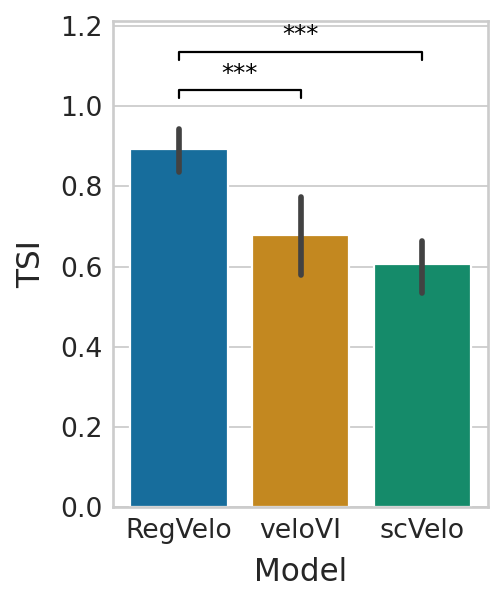

In [75]:
df = pd.DataFrame({"TSI": tsi + tsi_vi + tsi_scv, "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20})
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)

    ttest_res = wilcoxon(tsi, tsi_vi, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = wilcoxon(tsi, tsi_scv, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9)

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    # ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    # ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0]);
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "TSI_benchmark_update.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

In [76]:
### plot the recovery figure
df = pd.DataFrame(
    {
        "number_macrostate": range(0, 12),
        "RegVelo": [0] + pre_value_rgv,
        "veloVI": [0] + pre_value_vi,
        "scVelo": [0] + pre_value_scv,
    }
)
df = pd.melt(df, ["number_macrostate"])
colors = sns.color_palette("colorblind", n_colors=3)
colors = colors + [(0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

/tmp/ipykernel_1603380/2856647718.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)


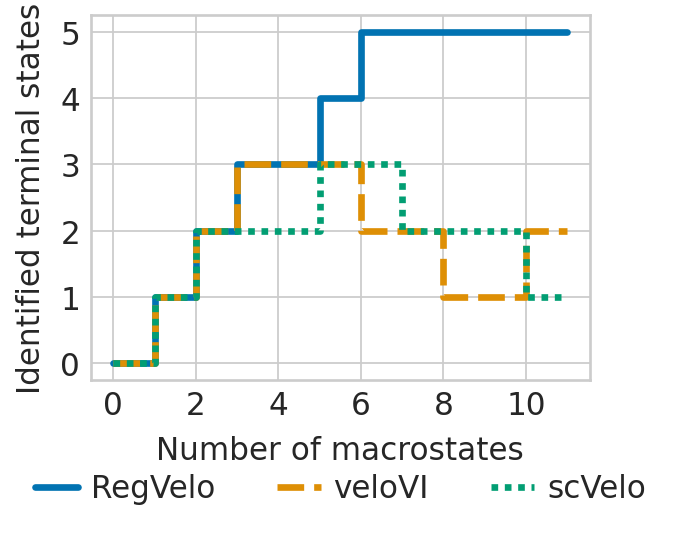

In [77]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    rcParams["figure.figsize"] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(
        x="number_macrostate",
        y="value",
        hue="variable",
        style="variable",
        palette=colors,
        drawstyle="steps-post",
        data=df,
        linewidth=3,
    )

    # Set labels and titles
    ax.set(ylabel="Number of correct predictions")
    plt.xlabel("Number of macrostates", fontsize=14)
    plt.ylabel("Identified terminal states", fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_xticklabels([0, 2, 4, 6, 8, 10])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4, fontsize=14)

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "state_identification.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

## Cell fate reproducibility test

In [78]:
adata_list = [
    DATA_DIR / "hematopoiesis" / "rgv_adata_runs_0.h5ad",
    DATA_DIR / "hematopoiesis" / "rgv_adata_runs_1.h5ad",
    DATA_DIR / "hematopoiesis" / "rgv_adata_runs_2.h5ad",
]

adata_rgv = sc.read_h5ad(adata_list[0])
cell_fate_rgv = cal_cell_fate(adata_rgv, terminal_states=["Mon", "Bas", "Ery", "Meg"], n_states=6)

adata_rgv = sc.read_h5ad(adata_list[1])
cell_fate_rgv2 = cal_cell_fate(adata_rgv, terminal_states=["Mon", "Bas", "Ery", "Meg"], n_states=6)

adata_rgv = sc.read_h5ad(adata_list[2])
cell_fate_rgv3 = cal_cell_fate(adata_rgv, terminal_states=["Mon", "Bas", "Ery", "Meg"], n_states=6)

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/5 [00:00<?, ?/s]

In [79]:
v1 = upper_triangular_correlation_values(np.array(cell_fate_rgv), np.array(cell_fate_rgv2))
v2 = upper_triangular_correlation_values(np.array(cell_fate_rgv3), np.array(cell_fate_rgv2))
v3 = upper_triangular_correlation_values(np.array(cell_fate_rgv), np.array(cell_fate_rgv3))

In [80]:
df_rgv = pd.DataFrame({"corr": v1 + v2 + v3, "terminal state": ["Mon", "Bas", "Ery", "Meg"] * 3})

In [81]:
adata_list = [
    "RegVelo_datasets/hematopoiesis/vi_adata_runs_0.h5ad",
    "RegVelo_datasets/hematopoiesis/vi_adata_runs_1.h5ad",
    "RegVelo_datasets/hematopoiesis/vi_adata_runs_2.h5ad",
]

adata_vi = sc.read_h5ad(adata_list[0])
cell_fate_vi = cal_cell_fate(adata_vi, terminal_states=["Mon", "Bas", "Ery", "Meg"], n_states=6)

adata_vi = sc.read_h5ad(adata_list[1])
cell_fate_vi2 = cal_cell_fate(adata_vi, terminal_states=["Mon", "Bas", "Ery", "Meg"], n_states=6)

adata_vi = sc.read_h5ad(adata_list[2])
cell_fate_vi3 = cal_cell_fate(adata_vi, terminal_states=["Mon", "Bas", "Ery", "Meg"], n_states=6)

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/5 [00:00<?, ?/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/5 [00:00<?, ?/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/5 [00:00<?, ?/s]

In [82]:
v1 = upper_triangular_correlation_values(np.array(cell_fate_vi), np.array(cell_fate_vi2))
v2 = upper_triangular_correlation_values(np.array(cell_fate_vi3), np.array(cell_fate_vi2))
v3 = upper_triangular_correlation_values(np.array(cell_fate_vi), np.array(cell_fate_vi3))

In [83]:
df_vi = pd.DataFrame({"corr": v1 + v2 + v3, "terminal state": ["Mon", "Bas", "Ery", "Meg"] * 3})

In [84]:
palette = dict(zip(adata_rgv.obs["cell_type"].cat.categories, adata_rgv.uns["cell_type_colors"]))

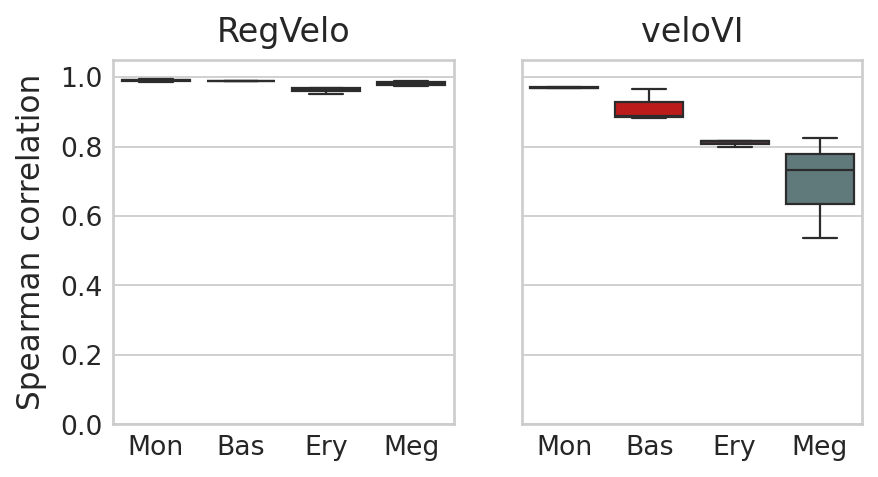

In [85]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)  # 1 row, 2 columns

    # Loop over the subplots and plot data for each run
    ax = axes[0]
    sns.boxplot(data=df_rgv, x="terminal state", y="corr", palette=palette, ax=ax)
    ax.set_title("RegVelo")
    ax.set_xlabel("")
    ax.set_ylabel("PCC")

    ax = axes[1]
    sns.boxplot(data=df_vi, x="terminal state", y="corr", palette=palette, ax=ax)
    ax.set_title("veloVI")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set a common ylabel
    axes[0].set_ylabel("Spearman correlation")
    plt.ylim(0, 1.05)

    # Show the plot

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / "fate_prob_reproducibility.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    plt.show()

## Visualize fate prob in FLE

In [86]:
g = cr.estimators.GPCCA(rgvk_new)
g.compute_macrostates(n_states=6, cluster_key="cell_type")
terminal_states = ["Mon", "Meg", "Bas", "Ery", "Neu"]
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()

  0%|          | 0/5 [00:00<?, ?/s]

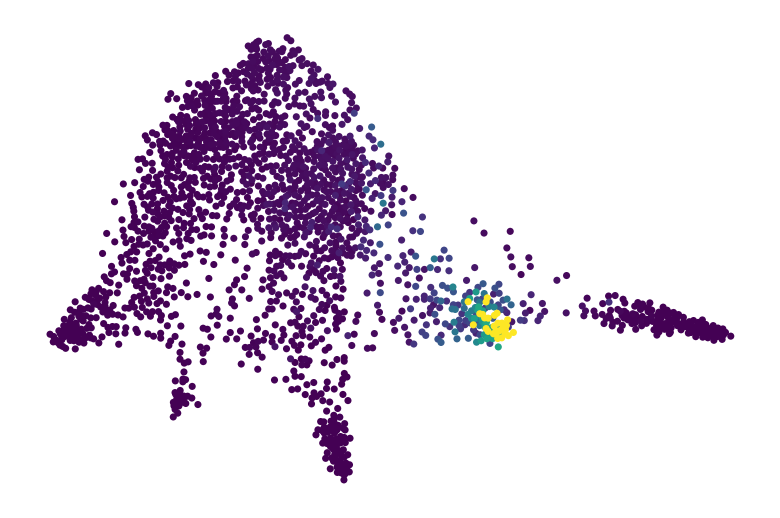

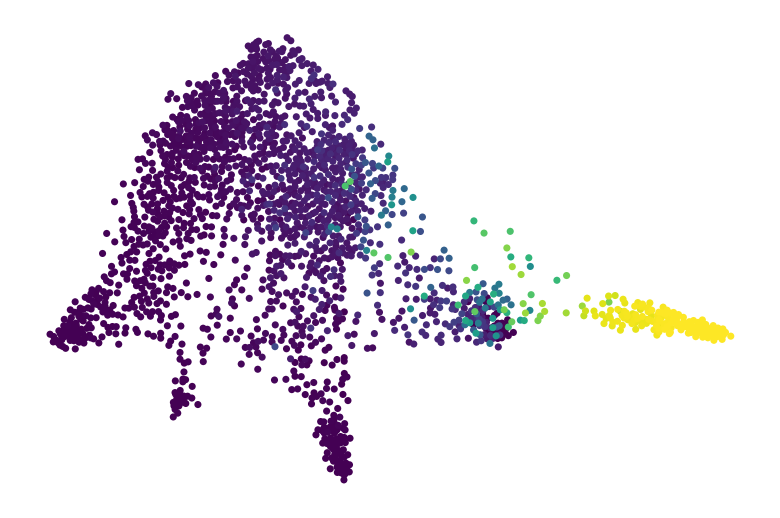

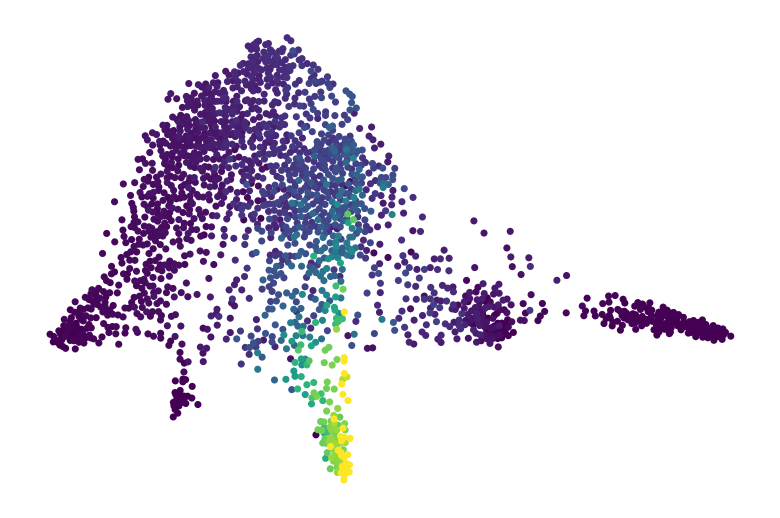

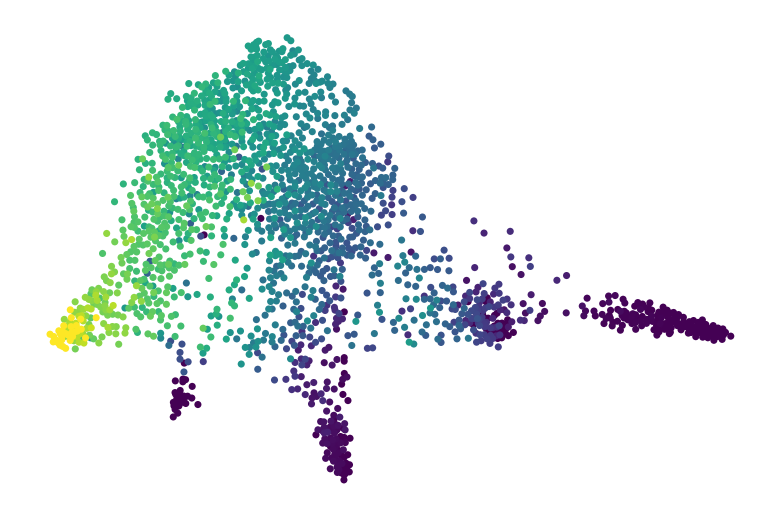

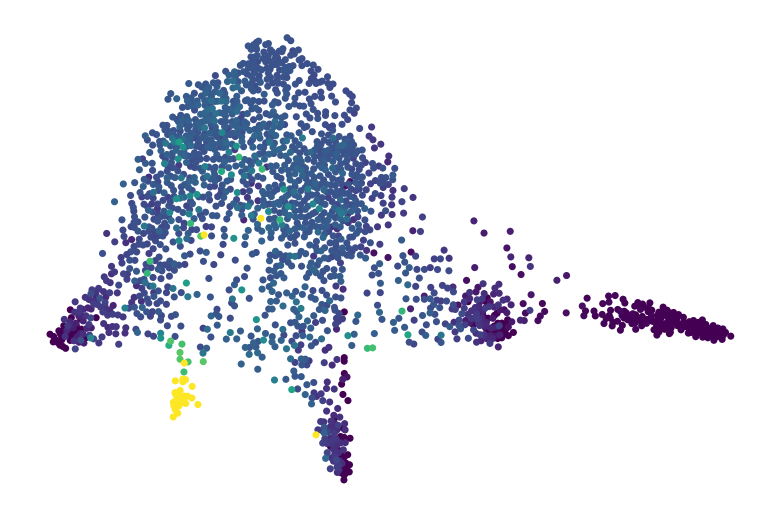

In [87]:
## return all fate probability predicted by RegVelo
adata_rgv = g.adata.copy()
adata_rgv.obs["fate_prob_Ery"] = adata_rgv.obsm["lineages_fwd"][:, "Ery"].X.squeeze()
adata_rgv.obs["fate_prob_Meg"] = adata_rgv.obsm["lineages_fwd"][:, "Meg"].X.squeeze()
adata_rgv.obs["fate_prob_Bas"] = adata_rgv.obsm["lineages_fwd"][:, "Bas"].X.squeeze()
adata_rgv.obs["fate_prob_Mon"] = adata_rgv.obsm["lineages_fwd"][:, "Mon"].X.squeeze()
adata_rgv.obs["fate_prob_Neu"] = adata_rgv.obsm["lineages_fwd"][:, "Neu"].X.squeeze()

for terminal_state in ["Ery", "Meg", "Bas", "Mon", "Neu"]:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata_rgv,
        basis="draw_graph_fa",
        color=f"fate_prob_{terminal_state}",
        cmap="viridis",
        title="",
        colorbar=False,
        ax=ax,
    )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "hematopoiesis" / "velocity_benchmark" / f"fate_prob_FLE_{terminal_state}.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )